**Chapter 9 – Unsupervised Learning**

_This notebook contains all the sample code in chapter 9._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Clustering

## Introduction – Classification _vs_ Clustering

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_plot


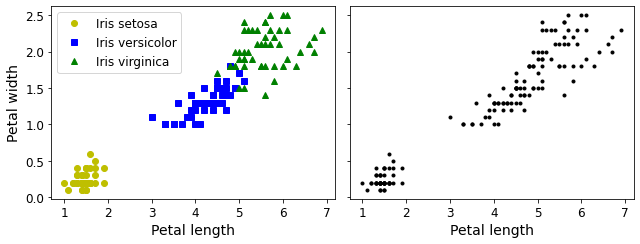

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping (as is done in the book, for simplicity), we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):

In [7]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [8]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

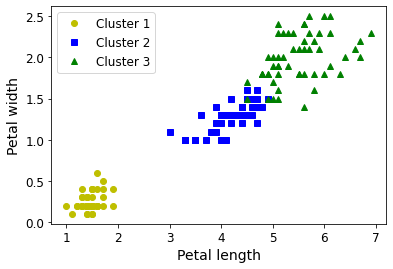

In [9]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [10]:
np.sum(y_pred==y)

145

In [11]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

**Note**: the results in this notebook may differ slightly from the book. This is because algorithms can sometimes be tweaked a bit between Scikit-Learn versions.

## K-Means

Let's start by generating some blobs:

In [12]:
from sklearn.datasets import make_blobs

In [13]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [14]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's plot them:

In [15]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


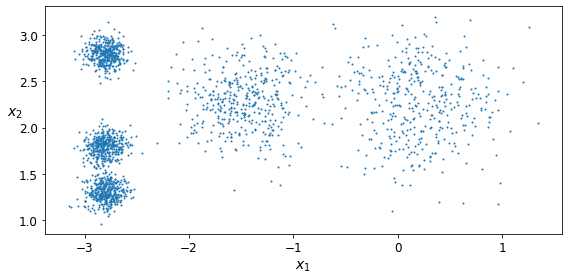

In [16]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [17]:
from sklearn.cluster import KMeans

In [18]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [19]:
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

In [20]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [21]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [22]:
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

Of course, we can predict the labels of new instances:

In [23]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [24]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


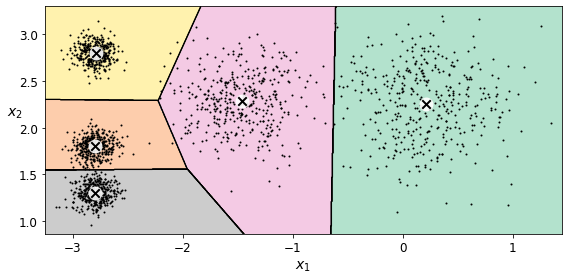

In [25]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

### Hard Clustering _vs_ Soft Clustering

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [26]:
kmeans.transform(X_new)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [27]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [28]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

And let's plot this:

Saving figure kmeans_algorithm_plot


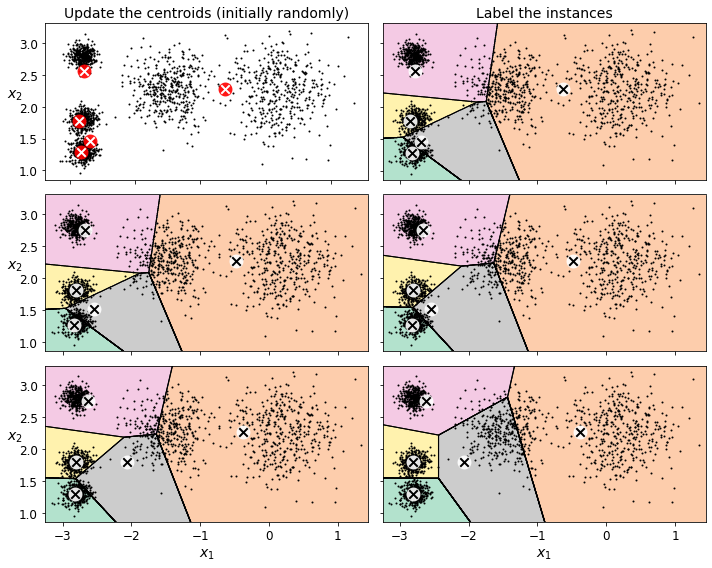

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [30]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


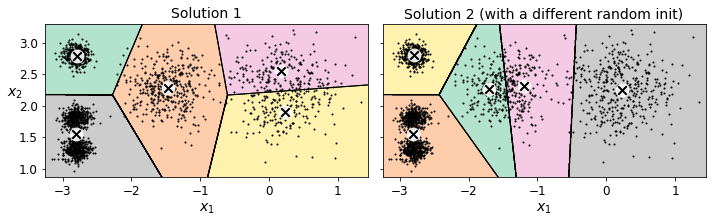

In [31]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [32]:
kmeans.inertia_

211.5985372581683

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [33]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581684

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [34]:
kmeans.score(X)

-211.5985372581683

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [35]:
kmeans_rnd_init1.inertia_

219.8438540223319

In [36]:
kmeans_rnd_init2.inertia_

236.95563196978728

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [37]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

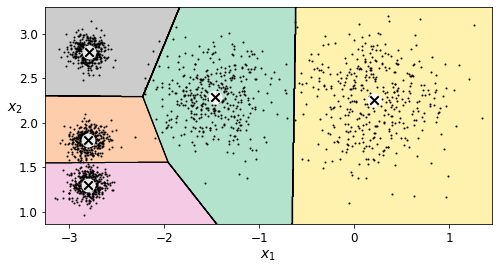

In [38]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [39]:
KMeans()

KMeans()

In [40]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.62337889822362

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [41]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

90.4 ms ± 612 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [42]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

91.6 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


There's no big difference in this case, as the dataset is fairly small.

### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [43]:
from sklearn.cluster import MiniBatchKMeans

In [44]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [45]:
minibatch_kmeans.inertia_

211.93186531476786

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

In [46]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Next, let's write it to a `memmap`:

In [48]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [49]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [50]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [51]:
np.random.seed(42)

In [52]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [53]:
best_kmeans.score(X)

-211.70999744411446

Mini-batch K-Means is much faster than regular K-Means:

In [54]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

45.7 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

10.2 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's *much* faster! However, its performance is often lower (higher inertia), and it keeps degrading as _k_ increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [56]:
from timeit import timeit

In [57]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Saving figure minibatch_kmeans_vs_kmeans


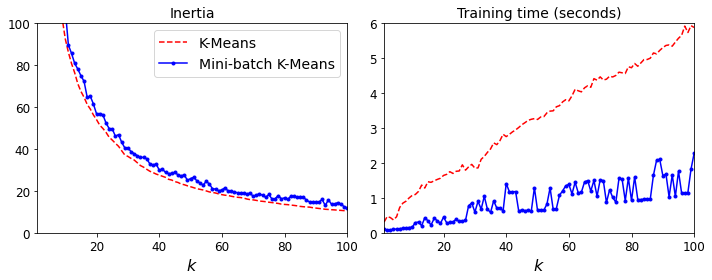

In [58]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

Saving figure bad_n_clusters_plot


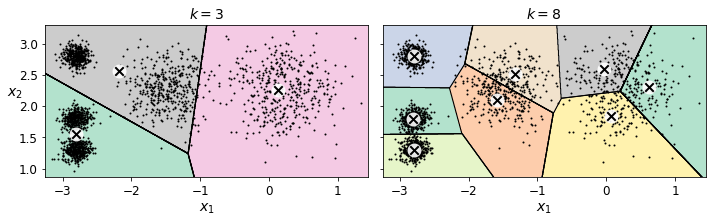

In [59]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [60]:
kmeans_k3.inertia_

653.2223267580945

In [61]:
kmeans_k8.inertia_

118.44108623570081

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [62]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


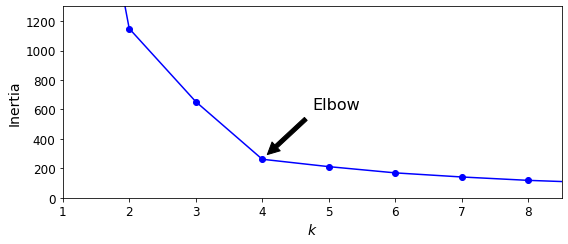

In [63]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

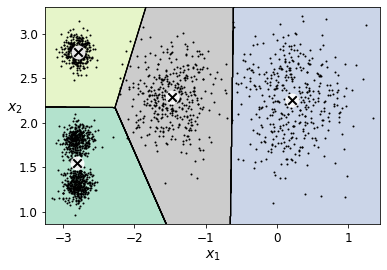

In [64]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [65]:
from sklearn.metrics import silhouette_score

In [66]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [67]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


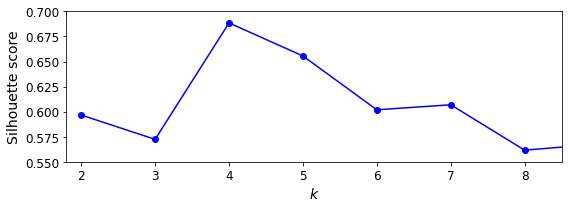

In [68]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

Saving figure silhouette_analysis_plot


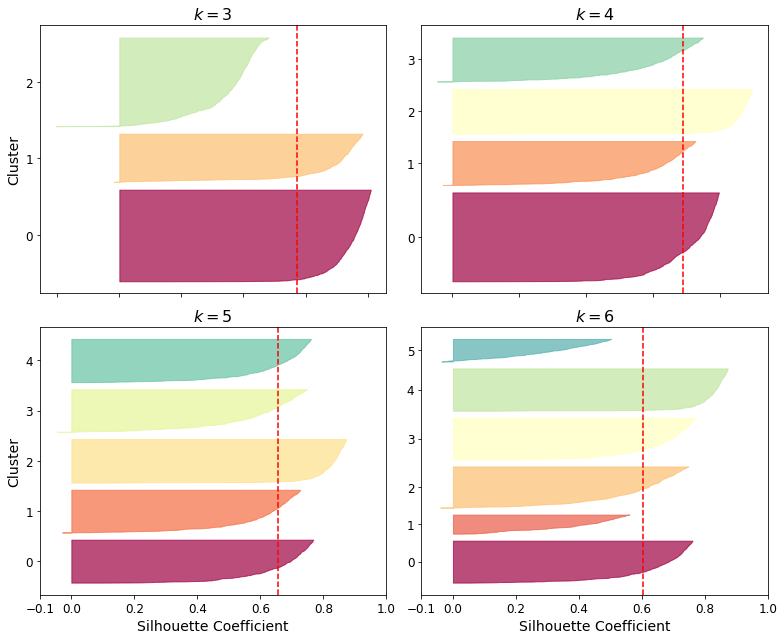

In [69]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

### Limits of K-Means

In [70]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

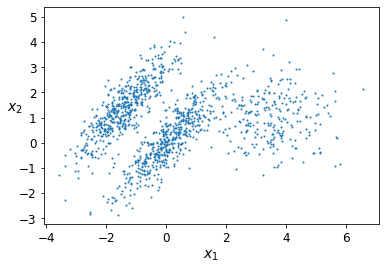

In [71]:
plot_clusters(X)

In [72]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


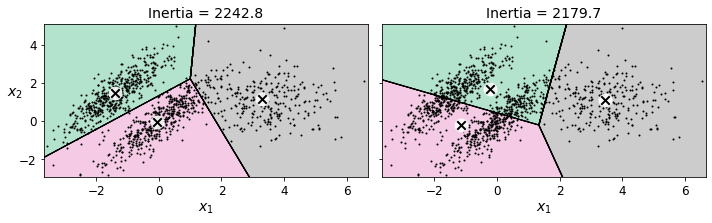

In [73]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

### Using clustering for image segmentation

In [74]:
# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fa4386b0090>)

In [75]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [76]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [77]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


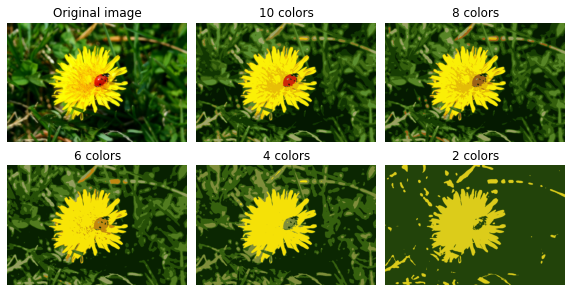

In [78]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Using Clustering for Preprocessing

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [79]:
from sklearn.datasets import load_digits

In [80]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [83]:
from sklearn.linear_model import LogisticRegression

In [84]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [85]:
log_reg.score(X_test, y_test)

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [86]:
from sklearn.pipeline import Pipeline

In [87]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [88]:
pipeline.score(X_test, y_test)

0.98

In [89]:
1 - (1 - 0.977777) / (1 - 0.968888)

0.28570969400874346

How about that? We reduced the error rate by over 28%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [90]:
from sklearn.model_selection import GridSearchCV

**Warning**: the following cell may take close to 20 minutes to run, or more depending on your hardware.

In [91]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 16.1min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

Let's see what the best number of clusters is:

In [92]:
grid_clf.best_params_

{'kmeans__n_clusters': 57}

In [93]:
grid_clf.score(X_test, y_test)

0.98

### Clustering for Semi-supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [94]:
n_labeled = 50

In [95]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [96]:
k = 50

In [97]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

Saving figure representative_images_diagram


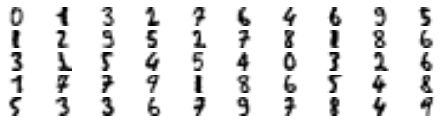

In [98]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [99]:
y_train[representative_digit_idx]

array([0, 1, 3, 2, 7, 6, 4, 6, 9, 5, 1, 2, 9, 5, 2, 7, 8, 1, 8, 6, 3, 1,
       5, 4, 5, 4, 0, 3, 2, 6, 1, 7, 7, 9, 1, 8, 6, 5, 4, 8, 5, 3, 3, 6,
       7, 9, 7, 8, 4, 9])

In [100]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 2, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [101]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9133333333333333

Wow! We jumped from 83.3% accuracy to 91.3%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [102]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [103]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [104]:
log_reg.score(X_test, y_test)

0.9244444444444444

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 75th percentile closest to the centroid:

In [105]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [106]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [107]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [108]:
log_reg.score(X_test, y_test)

0.9266666666666666

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 92.7% performance, which is getting closer to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is close to 96%:

In [109]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9592039800995025

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

## DBSCAN

In [110]:
from sklearn.datasets import make_moons

In [111]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [112]:
from sklearn.cluster import DBSCAN

In [113]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [114]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [115]:
len(dbscan.core_sample_indices_)

808

In [116]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [117]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [118]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [119]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [120]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


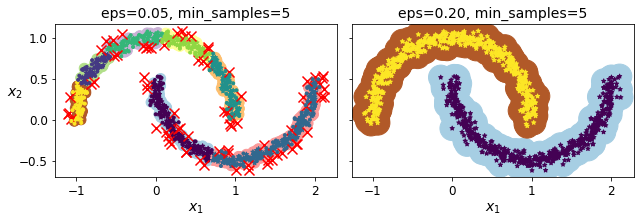

In [121]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


In [122]:
dbscan = dbscan2

In [123]:
from sklearn.neighbors import KNeighborsClassifier

In [124]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [125]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [126]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


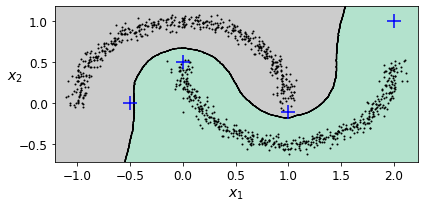

In [127]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [128]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Other Clustering Algorithms

### Spectral Clustering

In [129]:
from sklearn.cluster import SpectralClustering

In [130]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [131]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [132]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [133]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

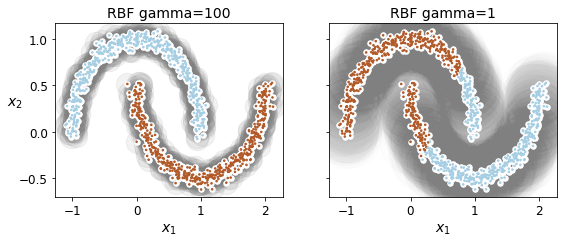

In [134]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Agglomerative Clustering

In [135]:
from sklearn.cluster import AgglomerativeClustering

In [136]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [137]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [138]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [139]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# Gaussian Mixtures

In [140]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [141]:
from sklearn.mixture import GaussianMixture

In [142]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [143]:
gm.weights_

array([0.39054348, 0.2093669 , 0.40008962])

In [144]:
gm.means_

array([[ 0.05224874,  0.07631976],
       [ 3.40196611,  1.05838748],
       [-1.40754214,  1.42716873]])

In [145]:
gm.covariances_

array([[[ 0.6890309 ,  0.79717058],
        [ 0.79717058,  1.21367348]],

       [[ 1.14296668, -0.03114176],
        [-0.03114176,  0.9545003 ]],

       [[ 0.63496849,  0.7298512 ],
        [ 0.7298512 ,  1.16112807]]])

Did the algorithm actually converge?

In [146]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [147]:
gm.n_iter_

4

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [148]:
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1])

In [149]:
gm.predict_proba(X)

array([[9.77227791e-01, 2.27715290e-02, 6.79898914e-07],
       [9.83288385e-01, 1.60345103e-02, 6.77104389e-04],
       [7.51824662e-05, 1.90251273e-06, 9.99922915e-01],
       ...,
       [4.35053542e-07, 9.99999565e-01, 2.17938894e-26],
       [5.27837047e-16, 1.00000000e+00, 1.50679490e-41],
       [2.32355608e-15, 1.00000000e+00, 8.21915701e-41]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [150]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.8690223 , -0.32680051],
       [ 0.29945755,  0.2841852 ],
       [ 1.85027284,  2.06556913],
       [ 3.98260019,  1.50041446],
       [ 3.82006355,  0.53143606],
       [-1.04015332,  0.7864941 ]])

In [151]:
y_new

array([0, 0, 1, 1, 1, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [152]:
gm.score_samples(X)

array([-2.60674489, -3.57074133, -3.33007348, ..., -3.51379355,
       -4.39643283, -3.8055665 ])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [153]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999271592

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [154]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure gaussian_mixtures_plot


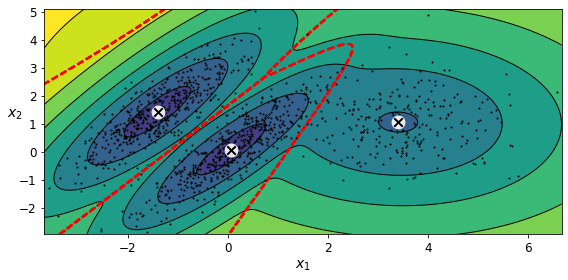

In [155]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [156]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [157]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


Saving figure covariance_type_plot


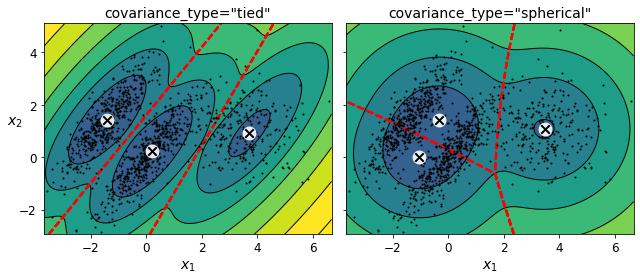

In [158]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

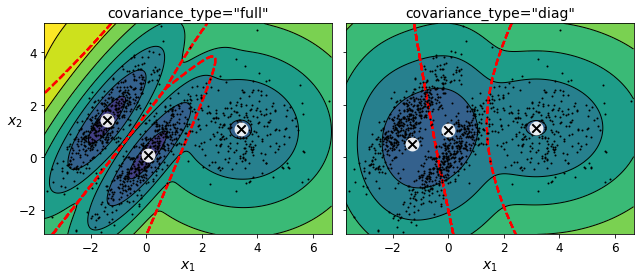

In [159]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [160]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Saving figure mixture_anomaly_detection_plot


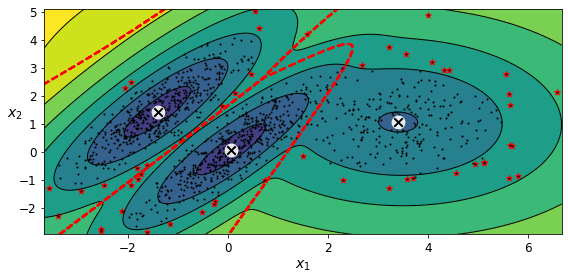

In [161]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## Model selection

We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [162]:
gm.bic(X)

8189.662685850681

In [163]:
gm.aic(X)

8102.437405735643

We could compute the BIC manually like this:

In [164]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [165]:
bic, aic

(8189.662685850681, 8102.437405735643)

In [166]:
n_params

17

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [167]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [168]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Saving figure aic_bic_vs_k_plot


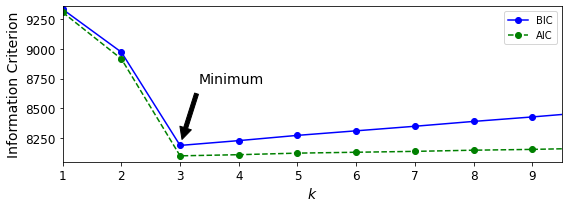

In [169]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

Let's search for best combination of values for both the number of clusters and the `covariance_type` hyperparameter:

In [170]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [171]:
best_k

3

In [172]:
best_covariance_type

'full'

## Variational Bayesian Gaussian Mixtures

Rather than manually searching for the optimal number of clusters, it is possible to use instead the `BayesianGaussianMixture` class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [173]:
from sklearn.mixture import BayesianGaussianMixture

In [174]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

The algorithm automatically detected that only 3 components are needed:

In [175]:
np.round(bgm.weights_, 2)

array([0.4 , 0.  , 0.  , 0.  , 0.39, 0.2 , 0.  , 0.  , 0.  , 0.  ])

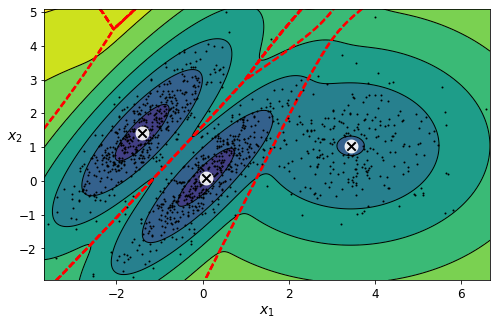

In [176]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [177]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [178]:
np.round(bgm_low.weights_, 2)

array([0.49, 0.51, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [179]:
np.round(bgm_high.weights_, 2)

array([0.43, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01, 0.37, 0.01, 0.01])

Saving figure mixture_concentration_prior_plot


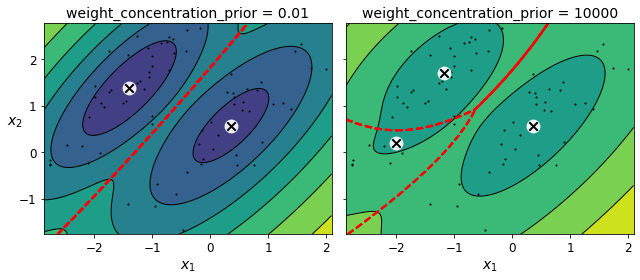

In [180]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

Note: the fact that you see only 3 regions in the right plot although there are 4 centroids is not a bug. The weight of the top-right cluster is much larger than the weight of the lower-right cluster, so the probability that any given point in this region belongs to the top right cluster is greater than the probability that it belongs to the lower-right cluster.

In [181]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [182]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

Saving figure moons_vs_bgm_plot


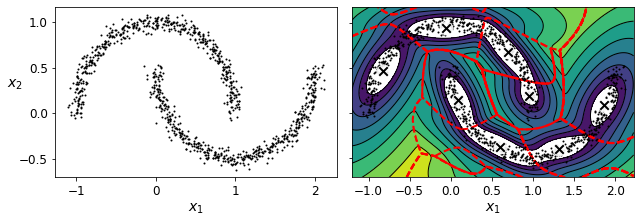

In [183]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

Oops, not great... instead of detecting 2 moon-shaped clusters, the algorithm detected 8 ellipsoidal clusters. However, the density plot does not look too bad, so it might be usable for anomaly detection.

## Likelihood Function

In [184]:
from scipy.stats import norm

In [185]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Saving figure likelihood_function_plot


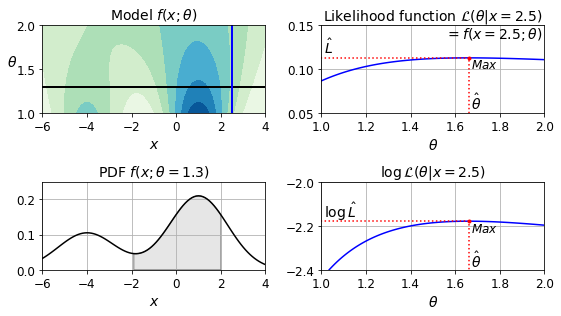

In [186]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("likelihood_function_plot")
plt.show()

# Exercise solutions

## 1. to 9.

See Appendix A.

## 10. Cluster the Olivetti Faces Dataset

*Exercise: The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function.*

In [187]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [188]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [189]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*Exercise: Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.*

In [190]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [191]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


To speed things up, we'll reduce the data's dimensionality using PCA:

In [192]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

*Exercise: Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).*

In [193]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


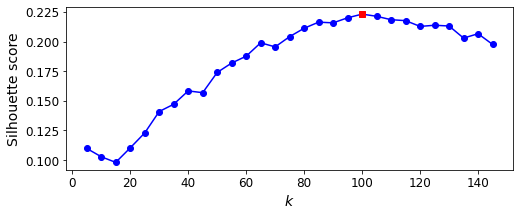

In [194]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [195]:
best_k

100

It looks like the best number of clusters is quite high, at 100. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

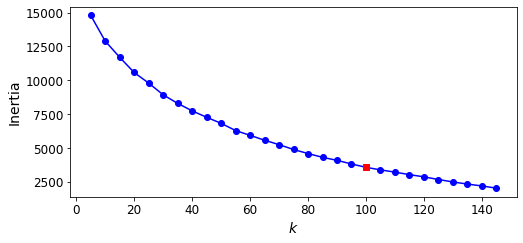

In [196]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=100.

In [197]:
best_model = kmeans_per_k[best_index]

*Exercise: Visualize the clusters: do you see similar faces in each cluster?*

Cluster 0


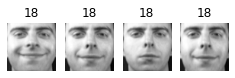

Cluster 1


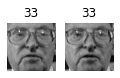

Cluster 2


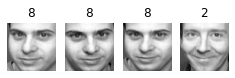

Cluster 3


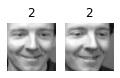

Cluster 4


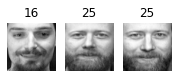

Cluster 5


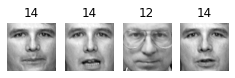

Cluster 6


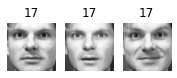

Cluster 7


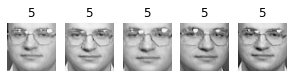

Cluster 8


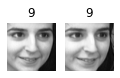

Cluster 9


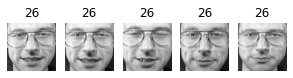

Cluster 10


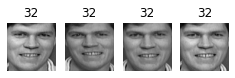

Cluster 11


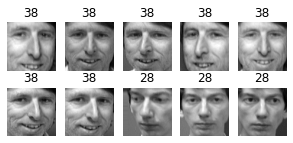

Cluster 12


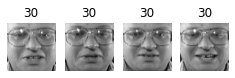

Cluster 13


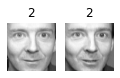

Cluster 14


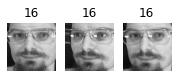

Cluster 15


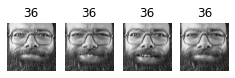

Cluster 16


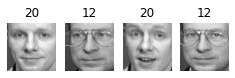

Cluster 17


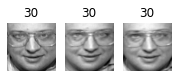

Cluster 18


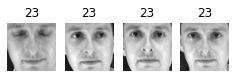

Cluster 19


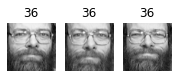

Cluster 20


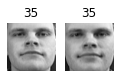

Cluster 21


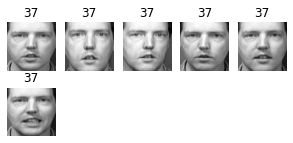

Cluster 22


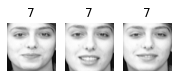

Cluster 23


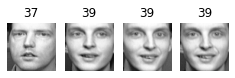

Cluster 24


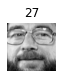

Cluster 25


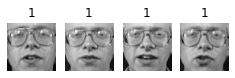

Cluster 26


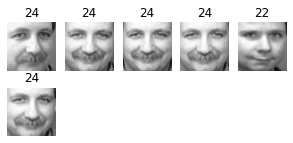

Cluster 27


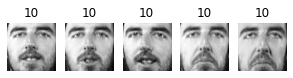

Cluster 28


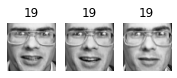

Cluster 29


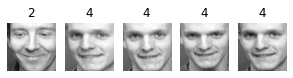

Cluster 30


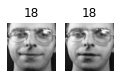

Cluster 31


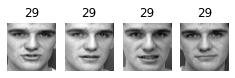

Cluster 32


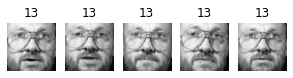

Cluster 33


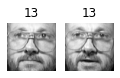

Cluster 34


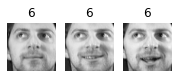

Cluster 35


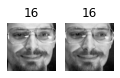

Cluster 36


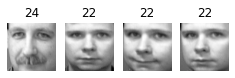

Cluster 37


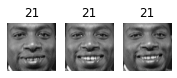

Cluster 38


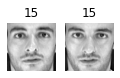

Cluster 39


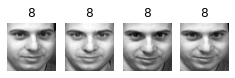

Cluster 40


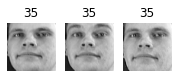

Cluster 41


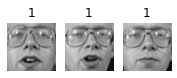

Cluster 42


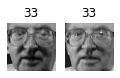

Cluster 43


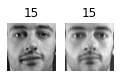

Cluster 44


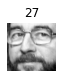

Cluster 45


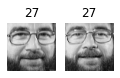

Cluster 46


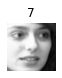

Cluster 47


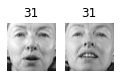

Cluster 48


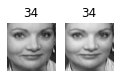

Cluster 49


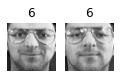

Cluster 50


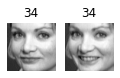

Cluster 51


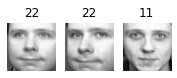

Cluster 52


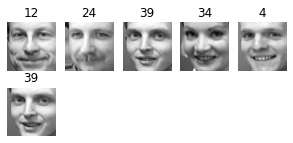

Cluster 53


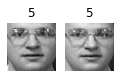

Cluster 54


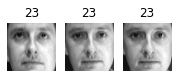

Cluster 55


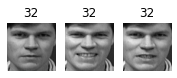

Cluster 56


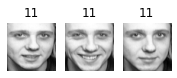

Cluster 57


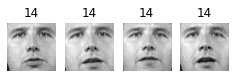

Cluster 58


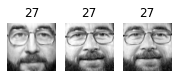

Cluster 59


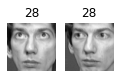

Cluster 60


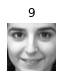

Cluster 61


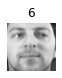

Cluster 62


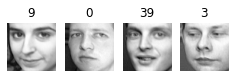

Cluster 63


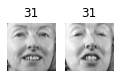

Cluster 64


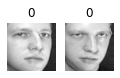

Cluster 65


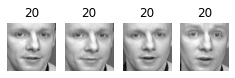

Cluster 66


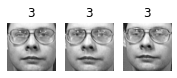

Cluster 67


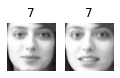

Cluster 68


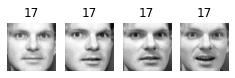

Cluster 69


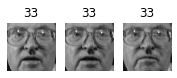

Cluster 70


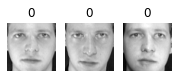

Cluster 71


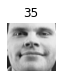

Cluster 72


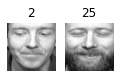

Cluster 73


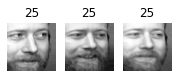

Cluster 74


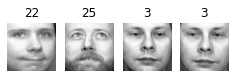

Cluster 75


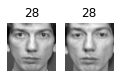

Cluster 76


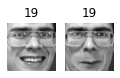

Cluster 77


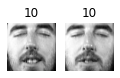

Cluster 78


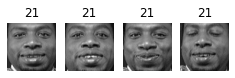

Cluster 79


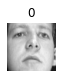

Cluster 80


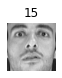

Cluster 81


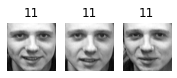

Cluster 82


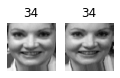

Cluster 83


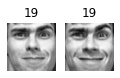

Cluster 84


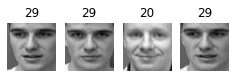

Cluster 85


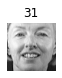

Cluster 86


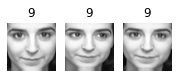

Cluster 87


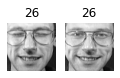

Cluster 88


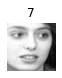

Cluster 89


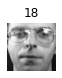

Cluster 90


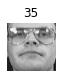

Cluster 91


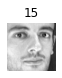

Cluster 92


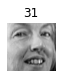

Cluster 93


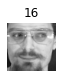

Cluster 94


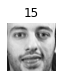

Cluster 95


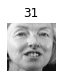

Cluster 96


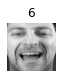

Cluster 97


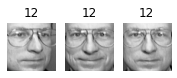

Cluster 98


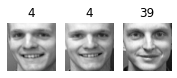

Cluster 99


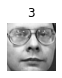

In [198]:
def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster].reshape(-1, 64, 64)
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

## 11. Using Clustering as Preprocessing for Classification

*Exercise: Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.*

In [199]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.9

*Exercise: Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.*

In [200]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.75

Yikes! That's not better at all! Let's see if tuning the number of clusters helps.

*Exercise: Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach?*

We could use a `GridSearchCV` like we did earlier in this notebook, but since we already have a validation set, we don't need K-fold cross-validation, and we're only exploring a single hyperparameter, so it's simpler to just run a loop manually:

In [201]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.3375
10 0.5375
15 0.5875
20 0.6625
25 0.65
30 0.7375
35 0.725
40 0.75
45 0.6875
50 0.7
55 0.725
60 0.775
65 0.7625
70 0.7
75 0.7625
80 0.725
85 0.7125
90 0.7125
95 0.75
100 0.675
105 0.7375
110 0.75
115 0.7375
120 0.7125
125 0.7625
130 0.7375
135 0.775
140 0.8
145 0.75


Oh well, even by tuning the number of clusters, we never get beyond 80% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

*Exercise: What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?*

In [202]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [203]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.825

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

## 12. A Gaussian Mixture Model for the Olivetti Faces Dataset

*Exercise: Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (e.g., use PCA, preserving 99% of the variance).*

In [204]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Exercise: Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method).*

In [205]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

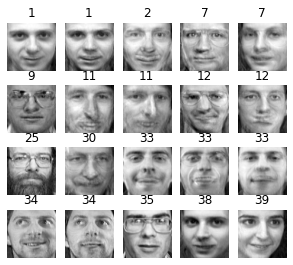

In [206]:
plot_faces(gen_faces, y_gen_faces)

*Exercise: Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies).*

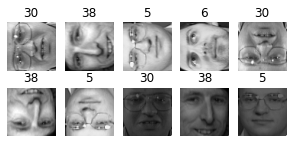

In [207]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [208]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [209]:
gm.score_samples(X_bad_faces_pca)

array([-1.79997530e+07, -2.26427432e+07, -3.96415305e+07, -4.60254251e+07,
       -3.13975243e+07, -1.39330383e+07, -2.90882868e+07, -1.06298605e+08,
       -1.20930968e+08, -7.49739808e+07])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [210]:
gm.score_samples(X_train_pca[:10])

array([1163.02020891, 1149.16682444, 1148.47710562, 1170.67602858,
       1088.46009659, 1075.71700227, 1075.71700662, 1088.46009034,
       1096.42609686, 1119.6862706 ])

## 13. Using Dimensionality Reduction Techniques for Anomaly Detection

*Exercise: Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.*

We already reduced the dataset using PCA earlier:

In [211]:
X_train_pca

array([[ 3.7808149e+00, -1.8547893e+00, -5.1440468e+00, ...,
        -1.3563596e-01, -2.1408217e-01,  6.1196767e-02],
       [ 1.0148848e+01, -1.5275438e+00, -7.6697463e-01, ...,
         1.2393678e-01, -1.3526531e-01, -2.3274131e-02],
       [-1.0015292e+01,  2.8772888e+00, -9.1988373e-01, ...,
         7.2611488e-02, -2.9624850e-03,  1.2489006e-01],
       ...,
       [ 2.4758708e+00,  2.9559720e+00,  1.2998564e+00, ...,
        -2.0914989e-02,  3.4853350e-02, -1.5432736e-01],
       [-3.2203126e+00,  5.3489790e+00,  1.3942705e+00, ...,
         5.7552867e-02, -2.2831078e-01,  1.5557358e-01],
       [-9.2287678e-01, -3.6470308e+00,  2.2608805e+00, ...,
         1.3685255e-01, -6.9130823e-02,  6.2687412e-02]], dtype=float32)

In [212]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [213]:
reconstruction_errors(pca, X_train).mean()

0.0001920535

In [214]:
reconstruction_errors(pca, X_bad_faces).mean()

0.004707354

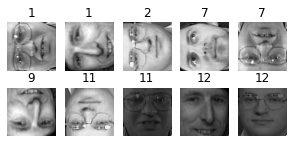

In [215]:
plot_faces(X_bad_faces, y_gen_faces)

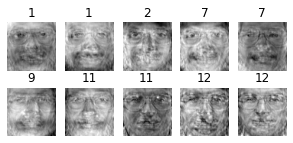

In [216]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_gen_faces)